# Taxi Ride Sharing 

The following code runs ride sharing algorithm for any given day (provided the path to the data folder is mentioned properly).The distances between the locations are precomputed in a different program.
Following are the steps to run the program :

1. Download all the data files from the location <a href="https://drive.google.com/drive/folders/1XZgTY6zH6bzb1sE9kz2yHRQ08YbAJavE?usp=sharing" > Data Files </a>.
2. The folder contains two main subfolders : Data folder and Distance Folder. Data ranges from Jan 2015 - Dec 2015.
3. Start the graphhopper server.
4. Input the path to the folders as mentioned by the program.
5. The code runs for two configuration : a.one day data b.For specified minutes.Select required option(note :This code can run for any year as specified by the user.But since the data downloaded in the 1st step corresponds to only 2015 Data input 2015 as year.
6. The code begins to run and outputs plots for From LGA and To LGA



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from h3 import h3
import json
from urllib.request import URLError, Request, urlopen
from itertools import combinations
from itertools import permutations
from dateutil import parser
from datetime import datetime, timedelta
import math
import networkx as nx
from tqdm import tqdm

In [4]:
# Check if graphhopper works
request_str = 'http://localhost:8989/route?point=' + str(40.760166) + '%2C' + str(-73.964760) + '&point=' + str(40.768780) + '%2C' + str(-73.867058) + '&vehicle=car'
request = Request(request_str)
res=requests.get(request_str)
print("Distance = {}".format(json.loads(res.text)['paths'][0]['distance']))
print("Time = {}".format(json.loads(res.text)['paths'][0]['time']))

Distance = 10640.72
Time = 627064


In [5]:
class Node:
    def __init__(self,idx,data):
        self.id = idx
        self.pickup_location = (data.pickup_latitude,data.pickup_longitude,data.pickup_h3)
        self.dropoff_location = (data.dropoff_latitude,data.dropoff_longitude,data.dropoff_h3)
        self.pickup_time = data.pickup_time
        self.dropoff_time = data.dropoff_time
        self.distance = data.trip_distance
        self.duration = data.duration
        self.delay = data.delay
        self.passenger_count = data.passenger_count

In [6]:
def get_distance_duration(node_a,node_b,trip_type):
    if trip_type==2: 
        e, f, g, h = node_a.pickup_location[0], node_a.pickup_location[1], node_b.pickup_location[0],node_b.pickup_location[1]
    else:
        e, f, g, h = node_a.dropoff_location[0], node_a.dropoff_location[1], node_b.dropoff_location[0],node_b.dropoff_location[1]
    request_str = 'http://localhost:8989/route?point=' + str(e) + '%2C' + str(f) + '&point=' + str(
        g) + '%2C' + str(h) + '&vehicle=car'
    request = Request(request_str)
    res = requests.get(request_str)
    if 'paths' in json.loads(res.text):
        distance = json.loads(res.text)['paths'][0]['distance']
        time = json.loads(res.text)['paths'][0]['time']
        minute, msec = divmod(time, 60000)
        return distance / 1609.344 , minute + (msec / 100000)
    else:
        return float('inf'),float('inf')
    

In [7]:
def get_all_pairs(node_a,node_b,trip_type):
    if trip_type == 1:
        #Combination LGA--> a -->b
        #if no distance call graphhopper 
        if (node_a.dropoff_location[2],node_b.dropoff_location[2]) not in df_distance.index:
            a_b_distance,a_b_duration = get_distance_duration(node_a,node_b,trip_type)
        else:
            a_b_distance = df_distance.loc[(node_a.dropoff_location[2],node_b.dropoff_location[2])]['distance']
            a_b_duration = df_distance.loc[(node_a.dropoff_location[2],node_b.dropoff_location[2])]['duration']
        
        LGA_a_dist = node_a.distance
        a_b_dist   = a_b_distance
        LGA_a_dur  = node_a.duration
        a_b_dur    = a_b_duration
        
        #Combination LGA--> b -->a
        if (node_b.dropoff_location[2],node_a.dropoff_location[2]) not in df_distance.index:
            b_a_distance,b_a_duration = get_distance_duration(node_a,node_b,trip_type)
        else:
            b_a_distance = df_distance.loc[(node_b.dropoff_location[2],node_a.dropoff_location[2])]['distance']
            b_a_duration = df_distance.loc[(node_b.dropoff_location[2],node_a.dropoff_location[2])]['duration']
            
        LGA_b_dist = node_b.distance
        b_a_dist = b_a_distance
        LGA_b_dur = node_b.duration
        b_a_dur = b_a_duration
        
        path_1_total_dis,path_1_total_dur = LGA_a_dist + a_b_dist,LGA_a_dur + a_b_dur 
        path_1_a_dur,path_1_b_dur = LGA_a_dur,path_1_total_dur
        
        path_2_total_dis,path_2_total_dur = LGA_b_dist+b_a_dist,LGA_b_dur+b_a_dur
        path_2_a_dur,path_2_b_dur         = path_2_total_dur ,LGA_b_dur
               
    else:
        #Combination a--> b --> LGA
        if (node_a.pickup_location[2],node_b.pickup_location[2]) not in df_distance.index:
            a_b_distance,a_b_duration = get_distance_duration(node_a,node_b,trip_type)
        else:
            a_b_distance = df_distance.loc[(node_a.pickup_location[2],node_b.pickup_location[2])]['distance']
            a_b_duration = df_distance.loc[(node_a.pickup_location[2],node_b.pickup_location[2])]['duration']
        
        a_b_dist   = a_b_distance
        b_LGA_dist = node_b.distance 
        a_b_dur    = a_b_duration
        b_LGA_dur  = node_b.duration
        
        #Combination b--> a --> LGA
        if (node_b.pickup_location[2],node_a.pickup_location[2]) not in df_distance.index:
            b_a_distance,b_a_duration = get_distance_duration(node_b,node_a,trip_type)
        else:
            b_a_distance = df_distance.loc[(node_b.pickup_location[2],node_a.pickup_location[2])]['distance']
            b_a_duration = df_distance.loc[(node_b.pickup_location[2],node_a.pickup_location[2])]['duration']
        
        b_a_dist   = b_a_distance
        a_LGA_dist = node_a.distance 
        b_a_dur    = b_a_duration
        a_LGA_dur  = node_a.duration
        
        path_1_total_dis,path_1_total_dur = a_b_dist + b_LGA_dist,a_b_dur + b_LGA_dur 
        path_1_a_dur,path_1_b_dur = path_1_total_dur,b_LGA_dur
        
        path_2_total_dis,path_2_total_dur, = b_a_dist+a_LGA_dist,b_a_dur+a_LGA_dur
        path_2_a_dur,path_2_b_dur         = a_LGA_dur,path_2_total_dur
        
    return ((path_1_total_dis,path_1_total_dur,path_1_a_dur,path_1_b_dur),( path_2_total_dis,path_2_total_dur,path_2_a_dur,path_2_b_dur))
    

In [8]:
def calculate_edge_weight(node_a,node_b,trip_type):
    path1,path2 = get_all_pairs(node_a,node_b,trip_type)
    minimum_distance = float('inf')
    for path in (path1,path2):
        distance_contraint = (path[0] <= node_a.distance + node_b.distance)
        delay_constraint = (path[2] <= node_a.duration + node_a.delay) & (path[3] <= node_b.duration + node_b.delay)
        #add social constraint too...
        
        
        if distance_contraint and delay_constraint and path[0]< minimum_distance:
            minimum_distance = path[0]
    distance_saved = node_a.distance + node_b.distance - minimum_distance
    return distance_saved

In [9]:
def get_rsg(G,trip_type):
    for node_a,node_b in list(combinations(G,2)):
        if (node_a.passenger_count+node_b.passenger_count)<=4:
            distance_saved = calculate_edge_weight(node_a,node_b,trip_type)
            if distance_saved!= float('-inf') :
                G.add_edge(node_a,node_b, weight=distance_saved)
    return G

# Average distance saved per pool as a % of total distance of individual rides

In [10]:
def Average_distance_saved(merged_trips,Final_Graph):
    with_sharing , without_sharing = [],[]
    for i in range(len(merged_trips)):
        all_nodes =  set()
        total_dis_before_merging = 0
        total_dis_after_merging = 0
        for each_node in Final_Graph[i].nodes:
            total_dis_before_merging += each_node.distance
            all_nodes.add(each_node)
        #remove merged nodes from orginal rga graph
        for u,v in merged_trips[i].edges:
            all_nodes.remove(u)
            all_nodes.remove(v)
            total_dis_after_merging += Final_Graph[i].get_edge_data(u,v)['weight']
        #add unmerged solo trips also
        for solo in all_nodes:
            total_dis_after_merging += solo.distance
        with_sharing.append(total_dis_after_merging)
        without_sharing.append(total_dis_before_merging)
    return(sum([(1-x/y) for x, y in zip(with_sharing, without_sharing)])/len(without_sharing) * 100)   

# Average number of trips saved per pool as a % of number of individual trips

In [11]:
def Average_trip_saved(merged_trips,Final_Graph):
    saved_rides = []
    for idx in range(len(merged_trips)):
        num_ind_trips = len(Final_Graph[idx].nodes)
        num_pooled_trips = len(merged_trips[idx].edges)
        saved_rides.append(num_pooled_trips/num_ind_trips * 100)
    return(sum(saved_rides)/len(saved_rides))

In [12]:
def main_algoritm(trip_type,excecution_time):
    start_execution = time.time()
    Final_Graph = []
    t = 0
    for _,trips in df.groupby(['pool_window']):
        nodes = []
        trips = trips.reset_index()
        for idx, row in trips.iterrows():
            nodes.append(Node(idx,trips.iloc[idx]))
        G = nx.Graph()
        G.add_nodes_from(nodes)
        Final_Graph.append(G)

    #Start of the code
    merged_trips = []
    cn=0
    for individual_graph in tqdm(Final_Graph,total=len(Final_Graph)):
        if int(excecution_time) > 0 and ((time.time() - start_execution)/60 >= float(excecution_time)):
            break
        s = time.time()
        ride_sharing_graph = get_rsg(individual_graph,trip_type)
        #maximum weighted algorithm
        maximum_weighted_graph = nx.max_weight_matching(ride_sharing_graph, maxcardinality=True)
        g_match = nx.Graph()
        for u,v in maximum_weighted_graph:
            g_match.add_edge(u,v)

        merged_trips.append(g_match)
        t += time.time()-s
    if int(excecution_time)>0:
        print("Number of pools processed in {} min :{}".format(excecution_time,len(merged_trips)))
    else:
        print("Number of pools processed for one day data:{}".format(len(merged_trips)))
    print("Average computation time is {} sec".format(t/len(merged_trips)))
    average_distance_saved = Average_distance_saved(merged_trips,Final_Graph)
    average_trip_saved = Average_trip_saved(merged_trips,Final_Graph)
    print("Average distance saved for poolwindow {} is :{}".format(pool_time_window,average_distance_saved))
    print("Average trip saved for poolwindow {} is :{}".format(pool_time_window,average_trip_saved)) 
    return pool_time_window,average_distance_saved,average_trip_saved,t/len(merged_trips)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
def plot_bar(df_results,label):
    a4_dims = (12, 9)
    sns.set(rc={'figure.figsize':(13,9)})
    ax = sns.barplot(x="Type", y="saved", hue="pool_window", data=df_results,palette="Blues_d")
    ax.set_xlabel('')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., 1*height,
                    '{}%'.format(round(height,2)),
                    ha='center', va='bottom')
    for ticks in ax.xaxis.get_major_ticks():
        ticks.label.set_fontsize(18)
    ax.set_ylabel('Average {} saved'.format(label),fontsize = 18)
    ax.set_title('Average {} for the June 6 2015 from 8am'.format(label),fontsize = 18)
    plt.show()
def plot_line(df_time):
    a4_dims = (12, 9)
    sns.set(rc={'figure.figsize':(13,9)})
    ax = sns.lineplot(x="pool_window", y="time", hue="Type", data=df_time,palette="Blues_d")
    ax.set_xlabel('')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., 1*height,
                    '{}%'.format(round(height,2)),
                    ha='center', va='bottom')
    for ticks in ax.xaxis.get_major_ticks():
        ticks.label.set_fontsize(18)
    ax.set_xlabel('pool windows in minute',fontsize = 18)    
    ax.set_ylabel('Time in seconds',fontsize = 18)
    ax.set_title('Average computation per pool',fontsize = 18)
    plt.show()
    

# FROM LGA  configuration

In [15]:
import time
def ceil_dt(dt, delta):
        return datetime.min + math.ceil((dt - datetime.min) / delta) * delta
excecution_time = 0
data_folder = input("Enter the absolute path to Data Folder:")
distance_folder = input("Enter the absolute path to distance Folder:")
mon = dict({'Jan':'1','Feb':'2','Mar':'3','Apr':'4','May':'5','June':'6','July':'7','Aug':'8','Sep':'9',\
            'Oct':'10','Nov':'11','Dec':'12'})
year = input("Enter year:")
Month = input ("Enter month:")
day = input("Enter day:")
running_type = input("What input data you want to run:\n 1.Run one day's data\n 2.Run the algorithm for given minutes:")
if running_type == '2':
    excecution_time = input("Enter excecution time in minutes:")
    strt_time = input("Enter start time in military format (00:00:00):")
month = mon[Month]

#reading distance and data file
file_name = str(data_folder)+'/LGA as pickup/LaGuardia_as_pickup_'+str(year)+'-'+str(Month)+'.csv'
distance_file_name = str(distance_folder)+'/LGA_as_pickup/'+year+'-'+month+'.csv'
df = pd.read_csv(file_name)
df_distance = pd.read_csv(distance_file_name)
df_distance.drop_duplicates(subset=['pickup_h3','dropoff_h3'],keep=False,inplace=True)
df_distance.set_index(['pickup_h3','dropoff_h3'],inplace= True)
df_distance = df_distance.sort_index()
#######################################################################################################

columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count',\
       'trip_distance', 'pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude']
df = df[columns]
df.rename(columns={'tpep_pickup_datetime':'pickup_time',
       'tpep_dropoff_datetime':'dropoff_time'},inplace=True)
drop_index=df[(df.pickup_latitude==0)|(df.pickup_longitude==0)|(df.trip_distance==0)].index
df.drop(drop_index,inplace=True)
df['pickup_time'] = pd.to_datetime(df['pickup_time'])
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'])
df['pickup_h3'] = df.apply(lambda x: h3.geo_to_h3(x['pickup_latitude'], x['pickup_longitude'], 15), axis=1)
df['dropoff_h3'] = df.apply(lambda x: h3.geo_to_h3(x['dropoff_latitude'], x['dropoff_longitude'], 15), axis=1)

if running_type =='1':
    start_date=str(year)+'-'+str(month)+'-'+str(day)+' 00:00:00'
    end_date=str(year)+'-'+str(month)+'-'+str(day)+' 23:59:59'
    df=df[(df['pickup_time'] >= start_date) & (df['dropoff_time'] <= end_date)]
else:
    start_date=str(year)+'-'+str(month)+'-'+str(day)+' '+str(strt_time)
    df=df[(df['pickup_time'] >= start_date)]

df.reset_index(drop=True,inplace=True)
df['duration'] = (df['pickup_time']-df['dropoff_time']).dt.seconds
df['delay'] = df['duration'].apply(lambda x: x*0.20)
df_results_distance_from = pd.DataFrame(columns =  ['pool_window','saved','Type'])
df_results_trip_from= pd.DataFrame(columns =  ['pool_window','saved','Type'])
df_time_from = pd.DataFrame(columns = ['pool_window','time','Type'])
for i,pool_time_window in enumerate(list([2,5,7])):
    start_time = time.time()
    df['pool_window'] = df['pickup_time'].apply(lambda x: ceil_dt(x.to_pydatetime(), timedelta(minutes=pool_time_window)))
    print("\nStarting main algorithm...")
    pool_time_window,average_distance_saved,average_trip_saved,pool_com_time = main_algoritm(1,excecution_time)
    df_results_distance_from.loc[i] = [pool_time_window,average_distance_saved,"From LGA"]
    df_results_trip_from.loc[i] = [ pool_time_window,average_trip_saved,"From LGA"]
    df_time_from.loc[i] =  [pool_time_window,pool_com_time,"From LGA"]
    total_time = (time.time()-start_time)/60.0
    print("algorithm time taken for {} pool window is :{} minutes\n ".format(pool_time_window,total_time))


Enter the absolute path to Data Folder:/home/shet/Documents/Data
Enter the absolute path to distance Folder:/home/shet/Documents/Distance
Enter year:2015
Enter month:June
Enter day:6
What input data you want to run:
 1.Run one day's data
 2.Run the algorithm for given minutes:2
Enter excecution time in minutes:5
Enter start time in military format (00:00:00):08:00:00

Starting main algorithm...


  8%|▊         | 1097/12999 [04:13<45:48,  4.33it/s]  


Number of pools processed in 5 min :1097
Average computation time is 0.2305241643893469 sec
Average distance saved for poolwindow 2 is :40.578049293561556
Average trip saved for poolwindow 2 is :34.561136593582916
algorithm time taken for 2 pool window is :5.014820392926534 minutes
 

Starting main algorithm...


  6%|▌         | 320/5543 [04:19<1:10:36,  1.23it/s]


Number of pools processed in 5 min :320
Average computation time is 0.8106322884559631 sec
Average distance saved for poolwindow 5 is :43.03048912973604
Average trip saved for poolwindow 5 is :36.937128553657786
algorithm time taken for 5 pool window is :5.048674925168355 minutes
 

Starting main algorithm...


  5%|▌         | 215/4055 [04:28<1:19:54,  1.25s/it]

Number of pools processed in 5 min :215
Average computation time is 1.2479195949643158 sec
Average distance saved for poolwindow 7 is :43.13843775011149
Average trip saved for poolwindow 7 is :37.371708250841316
algorithm time taken for 7 pool window is :5.0648331125577295 minutes
 


# TO LGA

In [16]:
#Reading distance and data file
file_name = data_folder+'/LGA as dropoff/LaGuardia_as_dropoff_'+str(year)+'-'+str(Month)+'.csv'
distance_file_name = distance_folder+'/LGA_drop_off/'+year+'-'+month+'.csv'
df = pd.read_csv(file_name)
df_distance = pd.read_csv(distance_file_name)
df_distance.drop_duplicates(subset=['pickup_h3','dropoff_h3'],keep=False,inplace=True)
df_distance.set_index(['pickup_h3','dropoff_h3'],inplace= True)
df_distance = df_distance.sort_index()
######################################################################################################

columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count',\
       'trip_distance', 'pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude']
df = df[columns]
df.rename(columns={'tpep_pickup_datetime':'pickup_time','tpep_dropoff_datetime':'dropoff_time'},inplace=True)
drop_index=df[(df.pickup_latitude==0)|(df.pickup_longitude==0)|(df.trip_distance==0)].index
df.drop(drop_index,inplace=True)
df['pickup_time'] = pd.to_datetime(df['pickup_time'])
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'])
df['pickup_h3'] = df.apply(lambda x: h3.geo_to_h3(x['pickup_latitude'], x['pickup_longitude'], 10), axis=1)
df['dropoff_h3'] = df.apply(lambda x: h3.geo_to_h3(x['dropoff_latitude'], x['dropoff_longitude'], 8), axis=1)

if running_type =='1':
    start_date=str(year)+'-'+str(month)+'-'+str(day)+' 00:00:00'
    end_date=str(year)+'-'+str(month)+'-'+str(day)+' 23:59:59'
    df=df[(df['pickup_time'] >= start_date) & (df['dropoff_time'] <= end_date)]
else:
    start_date=str(year)+'-'+str(month)+'-'+str(day)+' '+str(strt_time)
    df=df[(df['pickup_time'] >= start_date)]
    
df.reset_index(drop=True,inplace=True)
df['duration'] = (df['pickup_time']-df['dropoff_time']).dt.seconds
df['delay'] = df['duration'].apply(lambda x: x*0.20)
df_results_distance_to = pd.DataFrame(columns = ['pool_window','saved','Type'])
df_results_trip_to = pd.DataFrame(columns =  ['pool_window','saved','Type'])
df_time_to = pd.DataFrame(columns = ['pool_window','time','Type'])

for i,pool_time_window in enumerate(list([2,5,7])):
    start_time = time.time()
    df['pool_window'] = df['pickup_time'].apply(lambda x: ceil_dt(x.to_pydatetime(), timedelta(minutes=pool_time_window)))
    print("\nStarting main algorithm...")
    pool_time_window,average_distance_saved,average_trip_saved,pool_com_time = main_algoritm(2,excecution_time)
    df_results_distance_to.loc[i] = [pool_time_window,average_distance_saved,"To LGA"]
    df_results_trip_to.loc[i] = [pool_time_window,average_trip_saved,"To LGA"]
    df_time_to.loc[i] =  [pool_time_window,pool_com_time,"To LGA"]
    total_time = (time.time()-start_time)/60.0
    print("algorithm time taken for {} pool window is :{} minutes\n ".format(pool_time_window,total_time))


Starting main algorithm...


 26%|██▌       | 3296/12724 [04:31<12:57, 12.13it/s]  


Number of pools processed in 5 min :3296
Average computation time is 0.08221104704928629 sec
Average distance saved for poolwindow 2 is :35.16938466499972
Average trip saved for poolwindow 2 is :31.550313464355852
algorithm time taken for 2 pool window is :5.00964005390803 minutes
 

Starting main algorithm...


 13%|█▎        | 765/5840 [04:35<30:29,  2.77it/s]  


Number of pools processed in 5 min :765
Average computation time is 0.360078306759105 sec
Average distance saved for poolwindow 5 is :36.86352170443532
Average trip saved for poolwindow 5 is :33.95214084928978
algorithm time taken for 5 pool window is :5.016043241818746 minutes
 

Starting main algorithm...


  9%|▉         | 383/4361 [04:37<48:00,  1.38it/s]  

Number of pools processed in 5 min :383
Average computation time is 0.7237395754682178 sec
Average distance saved for poolwindow 7 is :36.02823132102995
Average trip saved for poolwindow 7 is :33.49692687443308
algorithm time taken for 7 pool window is :5.005791652202606 minutes
 


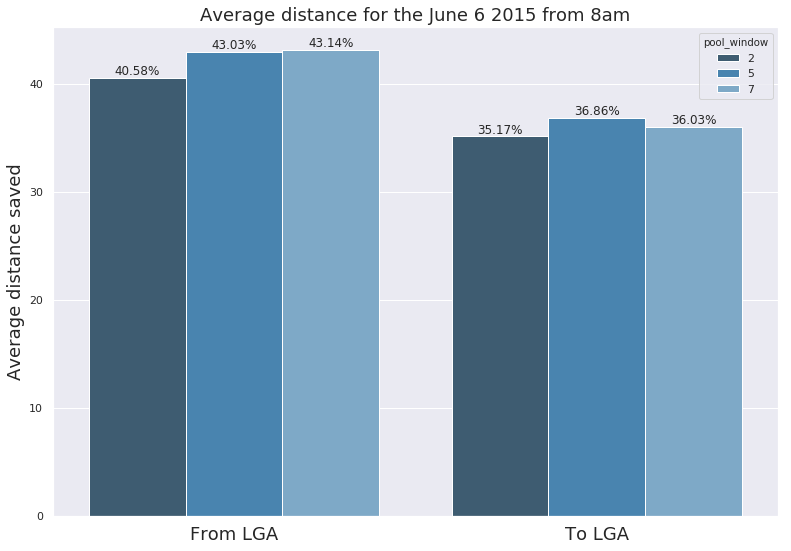

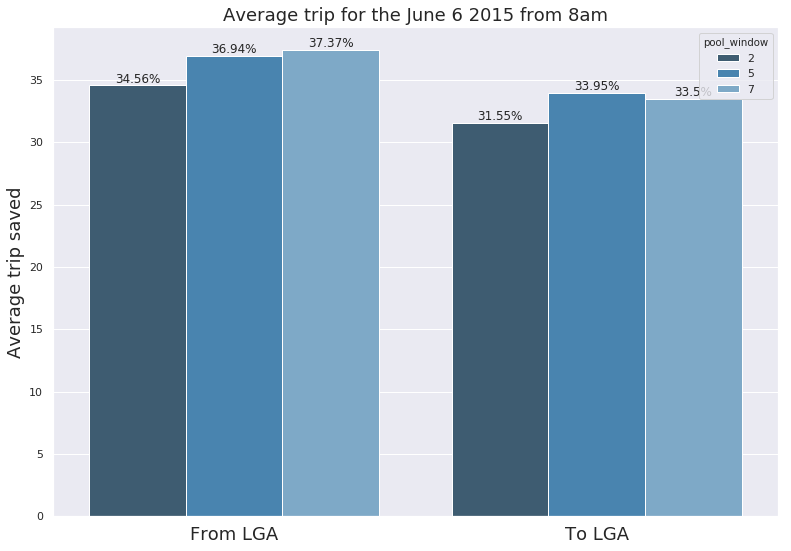

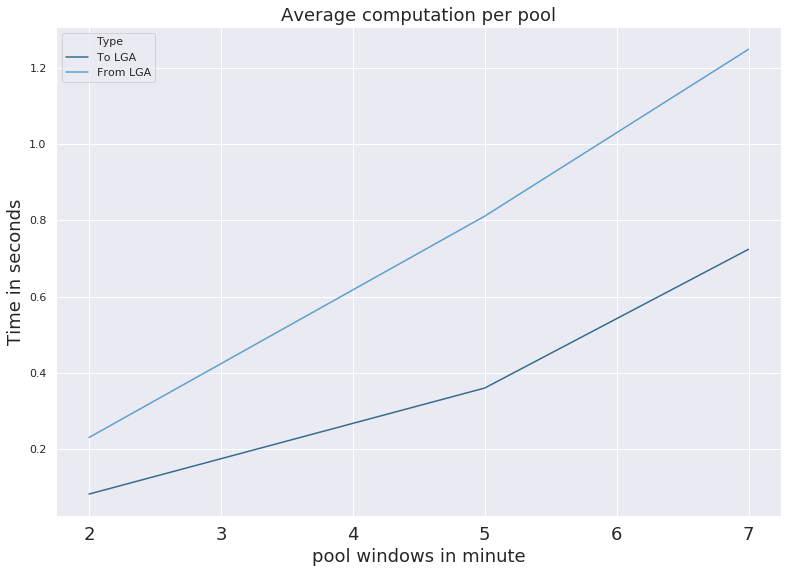

In [17]:
plot_bar(df_results_distance_from.append(df_results_distance_to),"distance")
plot_bar(df_results_trip_from.append(df_results_trip_to),"trip")
plot_line(df_time_to.append(df_time_from))